In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm

### Load grids and data

In [30]:
diag_frequency = "daily" # switch to "monthly" for testing

from loading import *
grid = load_baltic("zstr", diag_frequency)

### Specify target grid coordinates

In [31]:
# We specify our target density bins based on the online density-coordinate diagnostics
grid_ref = load_baltic("rho2", "monthly")
grid._ds = grid._ds.assign_coords({
    "sigma2_l_target": grid_ref._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
    "sigma2_i_target": grid_ref._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
})
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='extend'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='extend'):
  * center   z_l --> outer
  * outer    z_i --> center
Z_target Axis (not periodic, boundary='extend'):
  * center   sigma2_l_target --> outer
  * outer    sigma2_i_target --> center

# Part 1. Water mass budgets within a fixed sub-region

### Collecting high-level budget terms

In [32]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid._ds, budgets_dict)

### Specifying the horizontal boundaries of our water mass

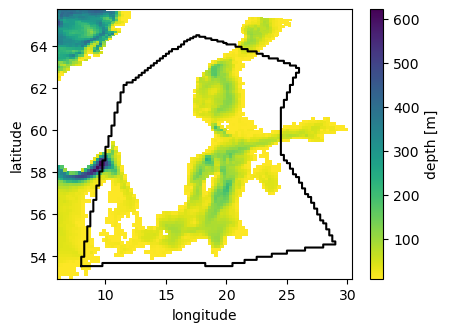

In [33]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");

### Computing water mass budgets

In [34]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        region
    )
    wmb.mass_budget(lam)
    wmb.wmt.load()
    wmt = wmb.wmt

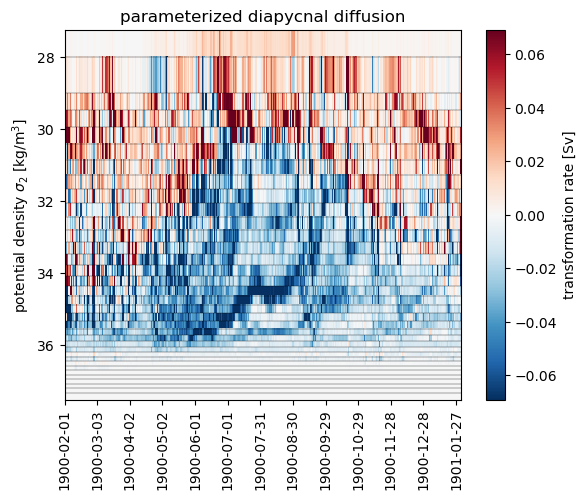

In [35]:
toSv = 1.e-6/wmb.rho_ref
pc = xwmb.hovmoller(wmt*toSv, "diffusion", cmap="RdBu_r", units="Sv", robust=True)
plt.ylim(37.5, 27.25);
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.title("parameterized diapycnal diffusion");

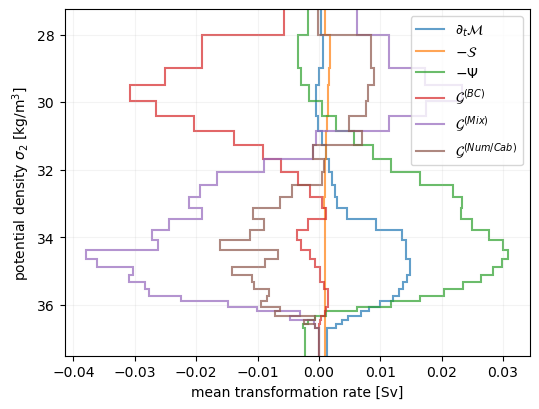

In [36]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_mean = wmt.mean('time')*toSv
xwmb.stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
xwmb.stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
xwmb.stairs(-wmt_mean, 'overturning',               label=r"$-\Psi$",                   **kwargs)
xwmb.stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BC)}$",      **kwargs)
xwmb.stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
xwmb.stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Num/Cab)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.15)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 27.25);

# Part 2. Global water mass budgets

### Minimal diagnostics for closing the mass budget and estimating physical and numerical mixing globally


In [37]:
region = xr.ones_like(grid._ds['deptho'])

When the region is taken to be the whole domain, the horizontal cross-boundary fluxes vanish either because there is no flow through land or because of lateral boundary conditions of no-normal flow or periodicity (e.g. at the zonal boundaries and tripolar grid fold). Rather than having to put in all of the effort to compute this vanishing term explicitly (and saving the required mass transport diagnostics), we can simply use the `assert_zero_transport` flag when instantiating the `WaterMassBudget` class.

**Note:** This probably needs to be revisiting for a regional domain, where there may be imposed normal flow at the boundaries... If that is the case, then the overturning would need to be included in the calculation.

Also, instead of working from the full MOM6 budget provided by `xbudget`, we here include the bare minimum budget information necessary to close the global water mass budget (and thereby diagnose numerical mixing). For closing the heat budget, for example, we only need 6 three-dimensional tendency diagnostics plus the snapshots of thickness to get the mass tendency.

In [38]:
grid = load_baltic("rho2", diag_frequency)
budgets_dict_minimal = xbudget.load_yaml("MOM6_num_mixing.yaml")
xbudget.collect_budgets(grid._ds, budgets_dict_minimal)

wmb_min = xwmb.WaterMassBudget(
    grid,
    budgets_dict_minimal,
    region,
    assert_zero_transport=True
)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_min.mass_budget(lam)
    wmb_min.wmt.load()
    wmt_min = wmb_min.wmt

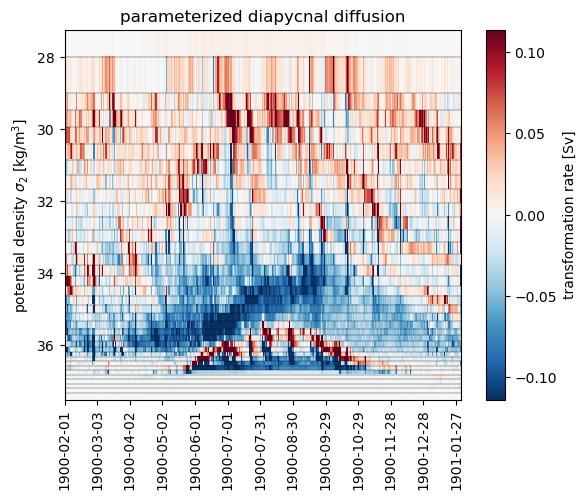

In [39]:
toSv = 1.e-6/wmb_min.rho_ref
pc = xwmb.hovmoller(wmt_min*toSv, "diffusion", cmap="RdBu_r", units="Sv", robust=True)
plt.ylim(37.5, 27.25);
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.title("parameterized diapycnal diffusion");

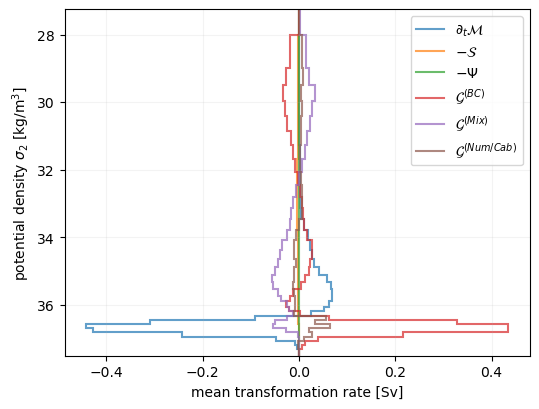

In [40]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_min_mean = wmt_min.mean('time')*toSv
xwmb.stairs( wmt_min_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
xwmb.stairs(-wmt_min_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
xwmb.stairs(-wmt_min_mean, 'overturning',               label=r"$-\Psi$",                   **kwargs)
xwmb.stairs( wmt_min_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BC)}$",      **kwargs)
xwmb.stairs( wmt_min_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
xwmb.stairs( wmt_min_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Num/Cab)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.15)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 27.25);